In [1]:
import sys
import json
from pathlib import Path
from collections import Counter

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from Bio import Entrez

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from entrez_tools.db.assembly import format_summary_meta

In [5]:
%matplotlib inline

## Code

In [6]:
sys.path.insert(0, './src')

from basic_esummary_store import BasicEsummaryStore

In [7]:
def chunk(l, chunksize: int):
    for start in range(0, len(l), chunksize):
        yield l[start:start + chunksize]

## Setup

In [8]:
DATESTR = '211109'
NBNAME = DATESTR + '-find-genomes'

In [9]:
Entrez.email = 'mjlumpe@gmail.com'
Entrez.api_key = 'adea2a53e6e44c3cc42c932f9ba4bdffa809'

In [10]:
processed_out = Path('data-processed') / NBNAME
processed_out.mkdir(exist_ok=True)

tmpdir = Path('tmp')
tmpdir.mkdir(exist_ok=True)

In [11]:
infiles = dict(
    esummary=Path('/home/jared/projects/gambit/data/ncbi/assembly/esummary/')
)

In [12]:
outfiles = dict(
    genomes=processed_out / 'genomes.csv',
    assembly_stats=processed_out / 'assembly-stats.csv',
)

## Search

In [13]:
TERM = '''\
"bacteria"[Organism] \
AND ("representative genome"[RefSeq Category] OR "reference genome"[RefSeq Category]) \
'''
# Not needed?
# AND "all"[Filter] NOT "anomalous"[Filter] \
# AND "latest"[Filter] \
# '''

In [14]:
response = Entrez.read(Entrez.esearch('assembly', TERM, retmax='99999'))

In [15]:
count = int(response['Count'])
assert response['RetStart'] == '0'
assert response['RetMax'] == str(count)
count

14388

In [16]:
ids = list(response['IdList'])
assert len(ids) == count

## Assemblies

In [17]:
summary_store = BasicEsummaryStore('assembly', infiles['esummary'])

### Download

In [18]:
to_download = set(ids) - summary_store.keys()

for uids in tqdm(list(chunk(list(to_download), 100))):
    with Entrez.esummary(db='assembly', id=','.join(uids), retmode='json') as response:
        data = json.load(response)

    assert set(data['result']['uids']) == set(uids)
    
    for uid in uids:
        summary = data['result'][uid]
        summary_store.add(summary)

0it [00:00, ?it/s]


### Extract data

In [19]:
summaries = {uid: summary_store[uid] for uid in tqdm(ids)}

100%|██████████| 14388/14388 [00:01<00:00, 12658.40it/s]


In [20]:
_rows = []

_VALS = dict(
    uid='uid',
    refseq_acc='assemblyaccession',
    refseq_category='refseq_category',
    taxid='taxid',
    organism='organism',
)

for summary in summaries.values():
    _row = {k1: summary[k2] for k1, k2 in _VALS.items()}
    _rows.append(_row)

genomes_df = pd.DataFrame.from_records(_rows)
genomes_df.set_index('uid', inplace=True)

In [21]:
_rows = []

_SUMMARY_KEYS = [
    ('uid', str),
    ('coverage', str),
]

_META_KEYS = [
    'assembly-level',
    'assembly-status',
    'total_length',
    'contig_count',
    'scaffold_count',
    'chromosome_count',
    'contig_n50',
    'scaffold_n50',
    'contig_l50',
    'scaffold_l50',
]

for summary in summaries.values():
    meta = format_summary_meta(summary['meta'])
    _row = {key: t(summary[key]) for key, t in _SUMMARY_KEYS}
    _row.update({key.replace('-', '_'): meta[key] for key in _META_KEYS})
    _row['coverage_num'] = float(_row['coverage'].lstrip('>'))
    _rows.append(_row)

assembly_stats = pd.DataFrame.from_records(_rows)
assembly_stats.set_index('uid', inplace=True)

## Inspect assembly data

In [22]:
Counter(s['refseq_category'] for s in summaries.values())

Counter({'representative genome': 14373, 'reference genome': 15})

In [23]:
genomes_df[[not acc.startswith('GCF_') for acc in genomes_df['refseq_acc']]]

,refseq_acc,refseq_category,taxid,organism
uid,,,,
10898551,GCA_003114835.2,representative genome,1917830,Leptospira kobayashii (bacteria)


In [24]:
property_counts = Counter()

for summary in summaries.values():
    property_counts.update(summary['propertylist'])
    
property_counts

Counter({'full-genome-representation': 14388,
         'genbank_has_annotation': 11266,
         'has_annotation': 14388,
         'latest': 14388,
         'latest_genbank': 14388,
         'latest_refseq': 14387,
         'refseq_has_annotation': 14386,
         'representative': 14388,
         'wgs': 10694,
         'from-type': 11050,
         'has-chromosome': 3751,
         'has-plasmid': 1218,
         'reference-guided': 101,
         'partial-genome-representation': 216,
         'has-extrachromosomal-element': 1})

In [25]:
Counter(s['assemblytype'] for s in summaries.values())

Counter({'haploid': 14388})

In [26]:
Counter(s['fromtype'] for s in summaries.values())

Counter({'': 3338,
         'assembly from type material': 10974,
         'assembly from synonym type material': 55,
         'assembly from pathotype material': 4,
         'assembly designated as neotype': 3,
         'assembly designated as reftype': 14})

In [27]:
[(uid, summary['anomalouslist']) for uid, summary in summaries.items() if summary['anomalouslist']]

[]

### Metadata assembly stats

In [28]:
assembly_stats.groupby(['assembly_level', 'assembly_status']).size()

assembly_level  assembly_status
1               Contig             6176
2               Scaffold           1156
3               Chromosome           55
4               Chromosome          319
6               Scaffold              6
8               Scaffold           3306
90              Complete Genome    3370
dtype: int64

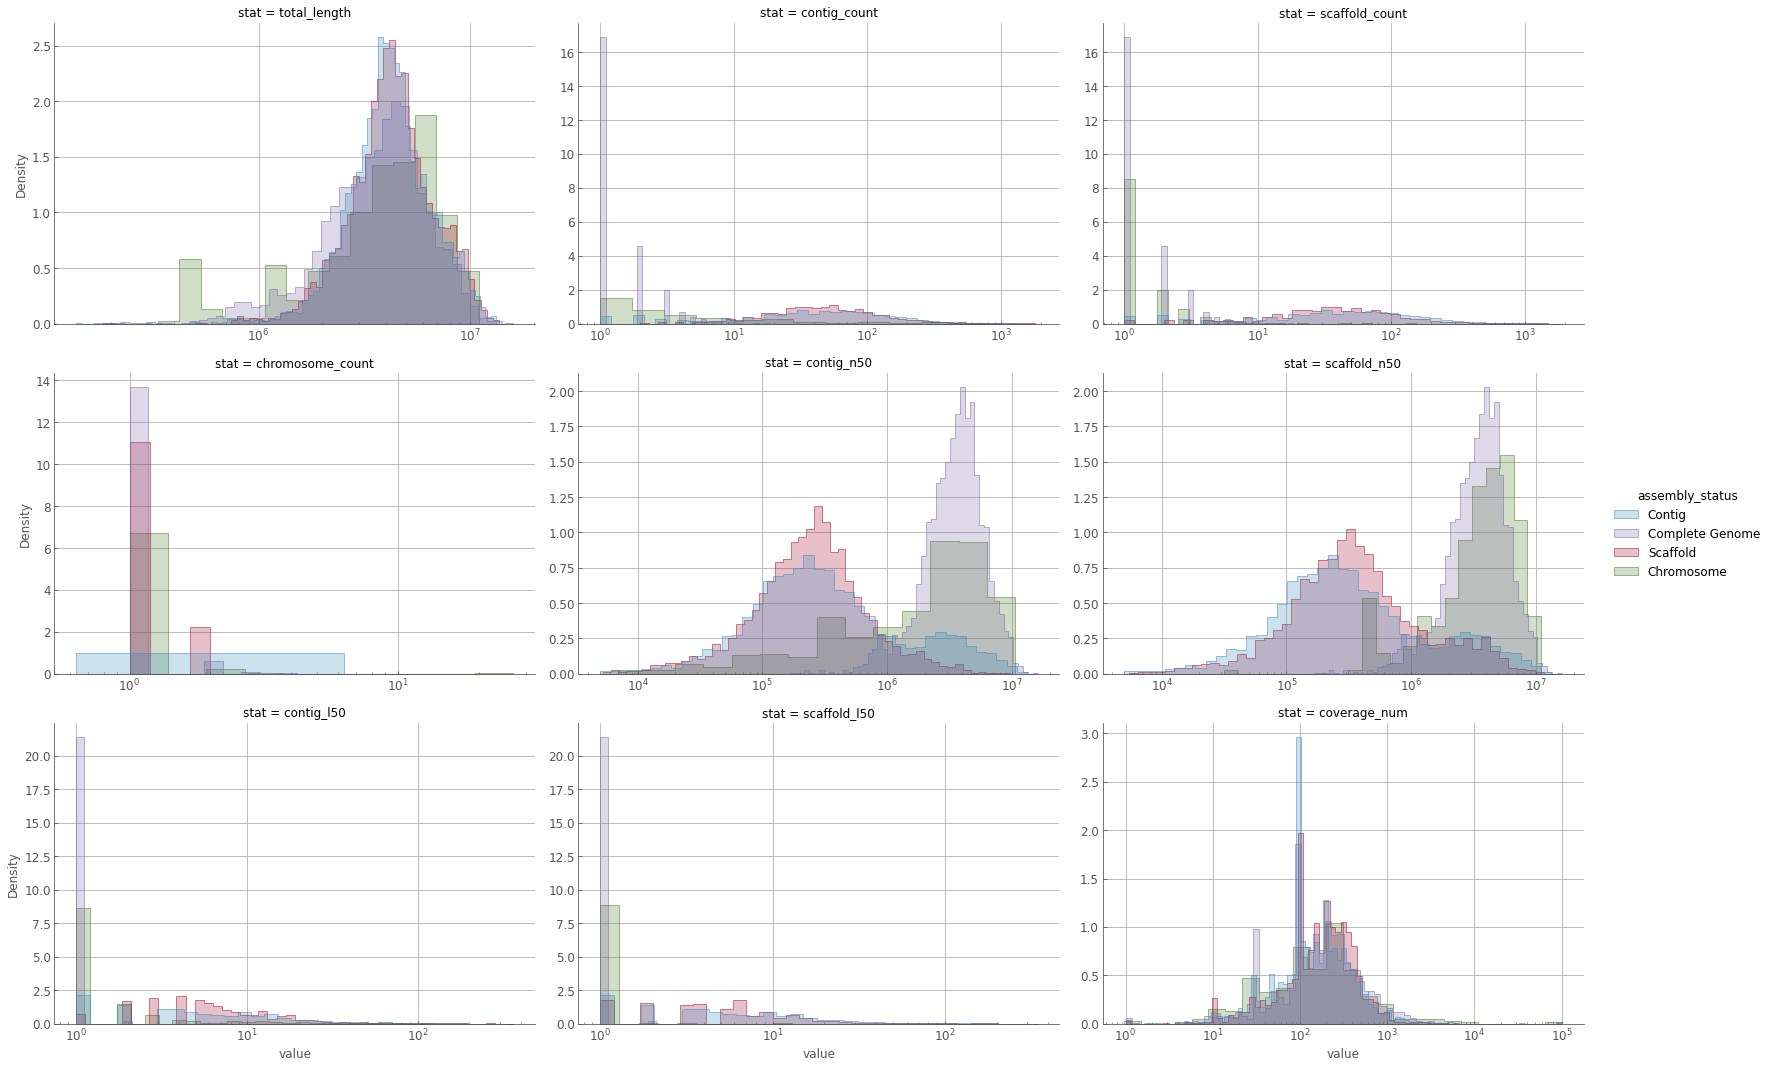

In [29]:
_data = assembly_stats.melt(
    id_vars=['assembly_level', 'assembly_status'],
    value_vars=[name for name, dt in assembly_stats.dtypes.iteritems() if dt.kind != 'O'],
    var_name='stat',
)

sns.displot(
    data=_data[_data['value'] > 0],
    kind='hist',
    x='value',
    col='stat',
    hue='assembly_status',
    element='step',
    stat='density',
    col_wrap=3,
    aspect=1.5,
    log_scale=True,
    common_bins=False,
    common_norm=False,
    facet_kws=dict(sharex=False, sharey=False),
)

## Write output

In [30]:
genomes_df.to_csv(outfiles['genomes'])

In [31]:
assembly_stats.to_csv(outfiles['assembly_stats'])